# EmptyDrops Performance Comparison: R vs Python

This notebook compares the FDR results between the R reference implementation (DropletUtils)
and the optimized Python implementation (pyEDv5) across multiple runs.

## Analysis Types
1. **Distribution Comparison** - Violin plots and KDE plots
2. **Agreement Analysis** - Bland-Altman plots
3. **Correlation Analysis** - Regression plots with R²
4. **Summary Statistics** - Mean, SD, and JS divergence

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import jensenshannon
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [5]:
# Load R results
r_log = pd.read_csv('../runs_R/run_log_r.csv')
print(f'R runs loaded: {len(r_log)} runs')

# Load Python results  
py_log = pd.read_csv('../runs/run_log.csv')
print(f'\nPython runs loaded: {len(py_log)} runs')

R runs loaded: 10 runs

Python runs loaded: 30 runs


In [6]:
# Filter for target niters
target_niters = 10000  # Change to 10000 if available

r_filtered = r_log[r_log['niters'] == target_niters].copy()
py_filtered = py_log[
    (py_log['niters'] == target_niters) & 
    (py_log['version'].isin(['v5_batched', 'v5_batched_FIXED']))
].copy()

print(f'Filtered for niters={target_niters}:')
print(f'  R runs: {len(r_filtered)}')
print(f'  Python runs: {len(py_filtered)}')

# Reshape data
def reshape_for_plotting(df, implementation):
    records = []
    for _, row in df.iterrows():
        for fdr_level in ['0.001', '0.01', '0.05']:
            col_name = f'fdr_{fdr_level.replace(".", "_")}'
            if col_name in df.columns:
                records.append({
                    'implementation': implementation,
                    'fdr_threshold': float(fdr_level),
                    'cells_called': row[col_name],
                    'runtime': row['runtime_seconds']
                })
    return pd.DataFrame(records)

r_long = reshape_for_plotting(r_filtered, 'R')
py_long = reshape_for_plotting(py_filtered, 'Python')
combined_long = pd.concat([r_long, py_long], ignore_index=True)

print(f'\nReshaped data:')
print(combined_long.groupby(['implementation', 'fdr_threshold']).size())

Filtered for niters=10000:
  R runs: 10
  Python runs: 10

Reshaped data:
implementation  fdr_threshold
Python          0.001            10
                0.010            10
                0.050            10
R               0.001            10
                0.010            10
                0.050            10
dtype: int64


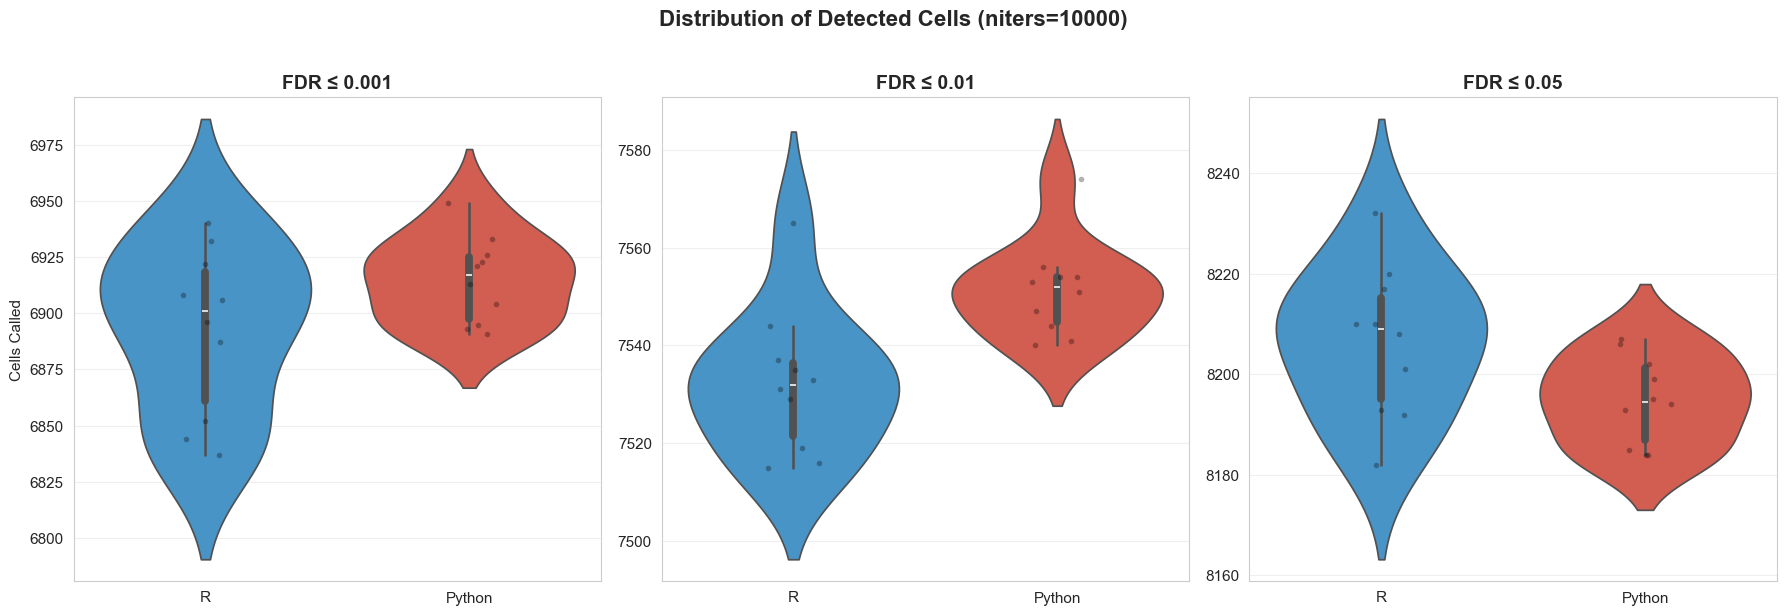

Violin plots saved to comparison_violin_plots.png


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, fdr in enumerate([0.001, 0.01, 0.05]):
    ax = axes[i]
    data_subset = combined_long[combined_long['fdr_threshold'] == fdr]
    
    sns.violinplot(data=data_subset, x='implementation', y='cells_called',
                   ax=ax, palette=['#3498db', '#e74c3c'], inner='box')
    sns.stripplot(data=data_subset, x='implementation', y='cells_called',
                  ax=ax, color='black', alpha=0.3, size=4)
    
    for j, impl in enumerate(['R', 'Python']):
        impl_data = data_subset[data_subset['implementation'] == impl]['cells_called']
        if len(impl_data) > 0:
            mean_val = impl_data.mean()
            std_val = impl_data.std()
    
    ax.set_title(f'FDR ≤ {fdr}', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Cells Called' if i == 0 else '')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle(f'Distribution of Detected Cells (niters={target_niters})', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('comparison_violin_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print('Violin plots saved to comparison_violin_plots.png')

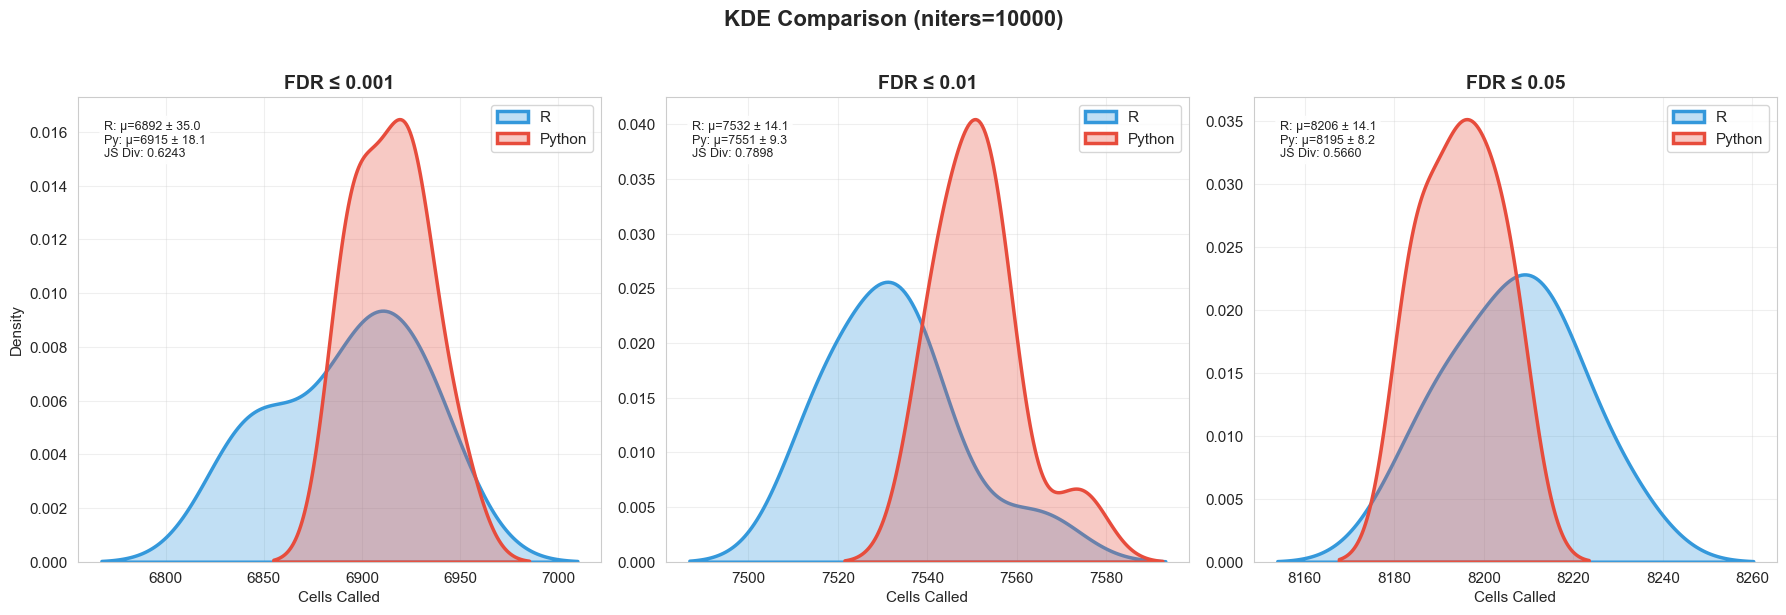

KDE plots saved to comparison_kde_plots.png


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, fdr in enumerate([0.001, 0.01, 0.05]):
    ax = axes[i]
    data_subset = combined_long[combined_long['fdr_threshold'] == fdr]
    
    r_data = data_subset[data_subset['implementation'] == 'R']['cells_called'].values
    py_data = data_subset[data_subset['implementation'] == 'Python']['cells_called'].values
    
    if len(r_data) > 1 and len(py_data) > 1:
        sns.kdeplot(data=r_data, ax=ax, label='R', color='#3498db', 
                   linewidth=2.5, fill=True, alpha=0.3)
        sns.kdeplot(data=py_data, ax=ax, label='Python', color='#e74c3c', 
                   linewidth=2.5, fill=True, alpha=0.3)
        
        r_mean, r_std = r_data.mean(), r_data.std()
        py_mean, py_std = py_data.mean(), py_data.std()
        
        # JS divergence
        bins = np.linspace(min(r_data.min(), py_data.min()),
                          max(r_data.max(), py_data.max()), 20)
        r_hist, _ = np.histogram(r_data, bins=bins, density=True)
        py_hist, _ = np.histogram(py_data, bins=bins, density=True)
        r_hist = (r_hist + 1e-10) / (r_hist + 1e-10).sum()
        py_hist = (py_hist + 1e-10) / (py_hist + 1e-10).sum()
        js_div = jensenshannon(r_hist, py_hist)
        
        stats_text = (f'R: μ={r_mean:.0f} ± {r_std:.1f}\n'
                     f'Py: μ={py_mean:.0f} ± {py_std:.1f}\n'
                     f'JS Div: {js_div:.4f}')
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
               va='top', ha='left', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_title(f'FDR ≤ {fdr}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cells Called')
    ax.set_ylabel('Density' if i == 0 else '')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle(f'KDE Comparison (niters={target_niters})', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('comparison_kde_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print('KDE plots saved to comparison_kde_plots.png')

In [9]:
summary_data = []

for fdr in [0.001, 0.01, 0.05]:
    r_data = combined_long[
        (combined_long['fdr_threshold'] == fdr) & 
        (combined_long['implementation'] == 'R')
    ]['cells_called'].values
    
    py_data = combined_long[
        (combined_long['fdr_threshold'] == fdr) & 
        (combined_long['implementation'] == 'Python')
    ]['cells_called'].values
    
    if len(r_data) > 0 and len(py_data) > 0:
        r_mean, r_std = r_data.mean(), r_data.std()
        py_mean, py_std = py_data.mean(), py_data.std()
        diff = py_mean - r_mean
        pct_diff = (diff / r_mean) * 100
        
        n_pairs = min(len(r_data), len(py_data))
        if n_pairs > 2:
            r_value, _ = stats.pearsonr(r_data[:n_pairs], py_data[:n_pairs])
        else:
            r_value = np.nan
        
        summary_data.append({
            'FDR': f'≤ {fdr}',
            'R Mean ± SD': f'{r_mean:.0f} ± {r_std:.1f}',
            'Python Mean ± SD': f'{py_mean:.0f} ± {py_std:.1f}',
            'Diff': f'{diff:.0f}',
            'Diff (%)': f'{pct_diff:.2f}%',
            'Pearson r': f'{r_value:.4f}' if not np.isnan(r_value) else 'N/A'
        })

summary_df = pd.DataFrame(summary_data)
print('\n' + '='*80)
print(f'SUMMARY STATISTICS (niters={target_niters})')
print('='*80)
print(summary_df.to_string(index=False))
print('='*80)

summary_df.to_csv('comparison_summary.csv', index=False)
print('\nSummary saved to comparison_summary.csv')


SUMMARY STATISTICS (niters=10000)
    FDR R Mean ± SD Python Mean ± SD Diff Diff (%) Pearson r
≤ 0.001 6892 ± 35.0      6915 ± 18.1   22    0.32%   -0.0363
 ≤ 0.01 7532 ± 14.1       7551 ± 9.3   19    0.25%   -0.0608
 ≤ 0.05 8206 ± 14.1       8195 ± 8.2  -12   -0.14%    0.1477

Summary saved to comparison_summary.csv


# Fraction Single

This plot shows which cells along the ranked UMI spectrum (all 15k cells above threshold)
are being called at different FDR thresholds by R vs Python.

The blue and red KDE curves show the density of called cells across the ranked positions,
revealing overlap in detected cell populations between implementations.

=== Creating Difference Curve (Δ Fraction) Plot ===
Found 10 R files and 10 Python files

Closest runs (diff = 0 cells):
  R: run_10_results.csv (8193 cells)
  Py: niters10000_results_20251027_114828.csv (8193 cells)

Furthest runs (diff = 48 cells):
  R: run_7_results.csv (8232 cells)
  Py: niters10000_results_20251027_115503.csv (8184 cells)

=== Processing Closest Agreement ===
R: run_10_results.csv - 722431 cells
Py: niters10000_results_20251027_114828.csv - 722431 cells
Test cells (>100 UMI): R=15000, Py=15000

Calculating difference curves for Closest Agreement:
FDR ≤ 0.001: R=6896, Py=6933, Diff=+37
FDR ≤ 0.01: R=7529, Py=7547, Diff=+18
FDR ≤ 0.05: R=8193, Py=8193, Diff=+0

=== Processing Furthest Apart ===
R: run_7_results.csv - 722431 cells
Py: niters10000_results_20251027_115503.csv - 722431 cells
Test cells (>100 UMI): R=15000, Py=15000

Calculating difference curves for Furthest Apart:
FDR ≤ 0.001: R=6940, Py=6895, Diff=-45
FDR ≤ 0.01: R=7565, Py=7551, Diff=-14
FDR ≤ 0.05: 

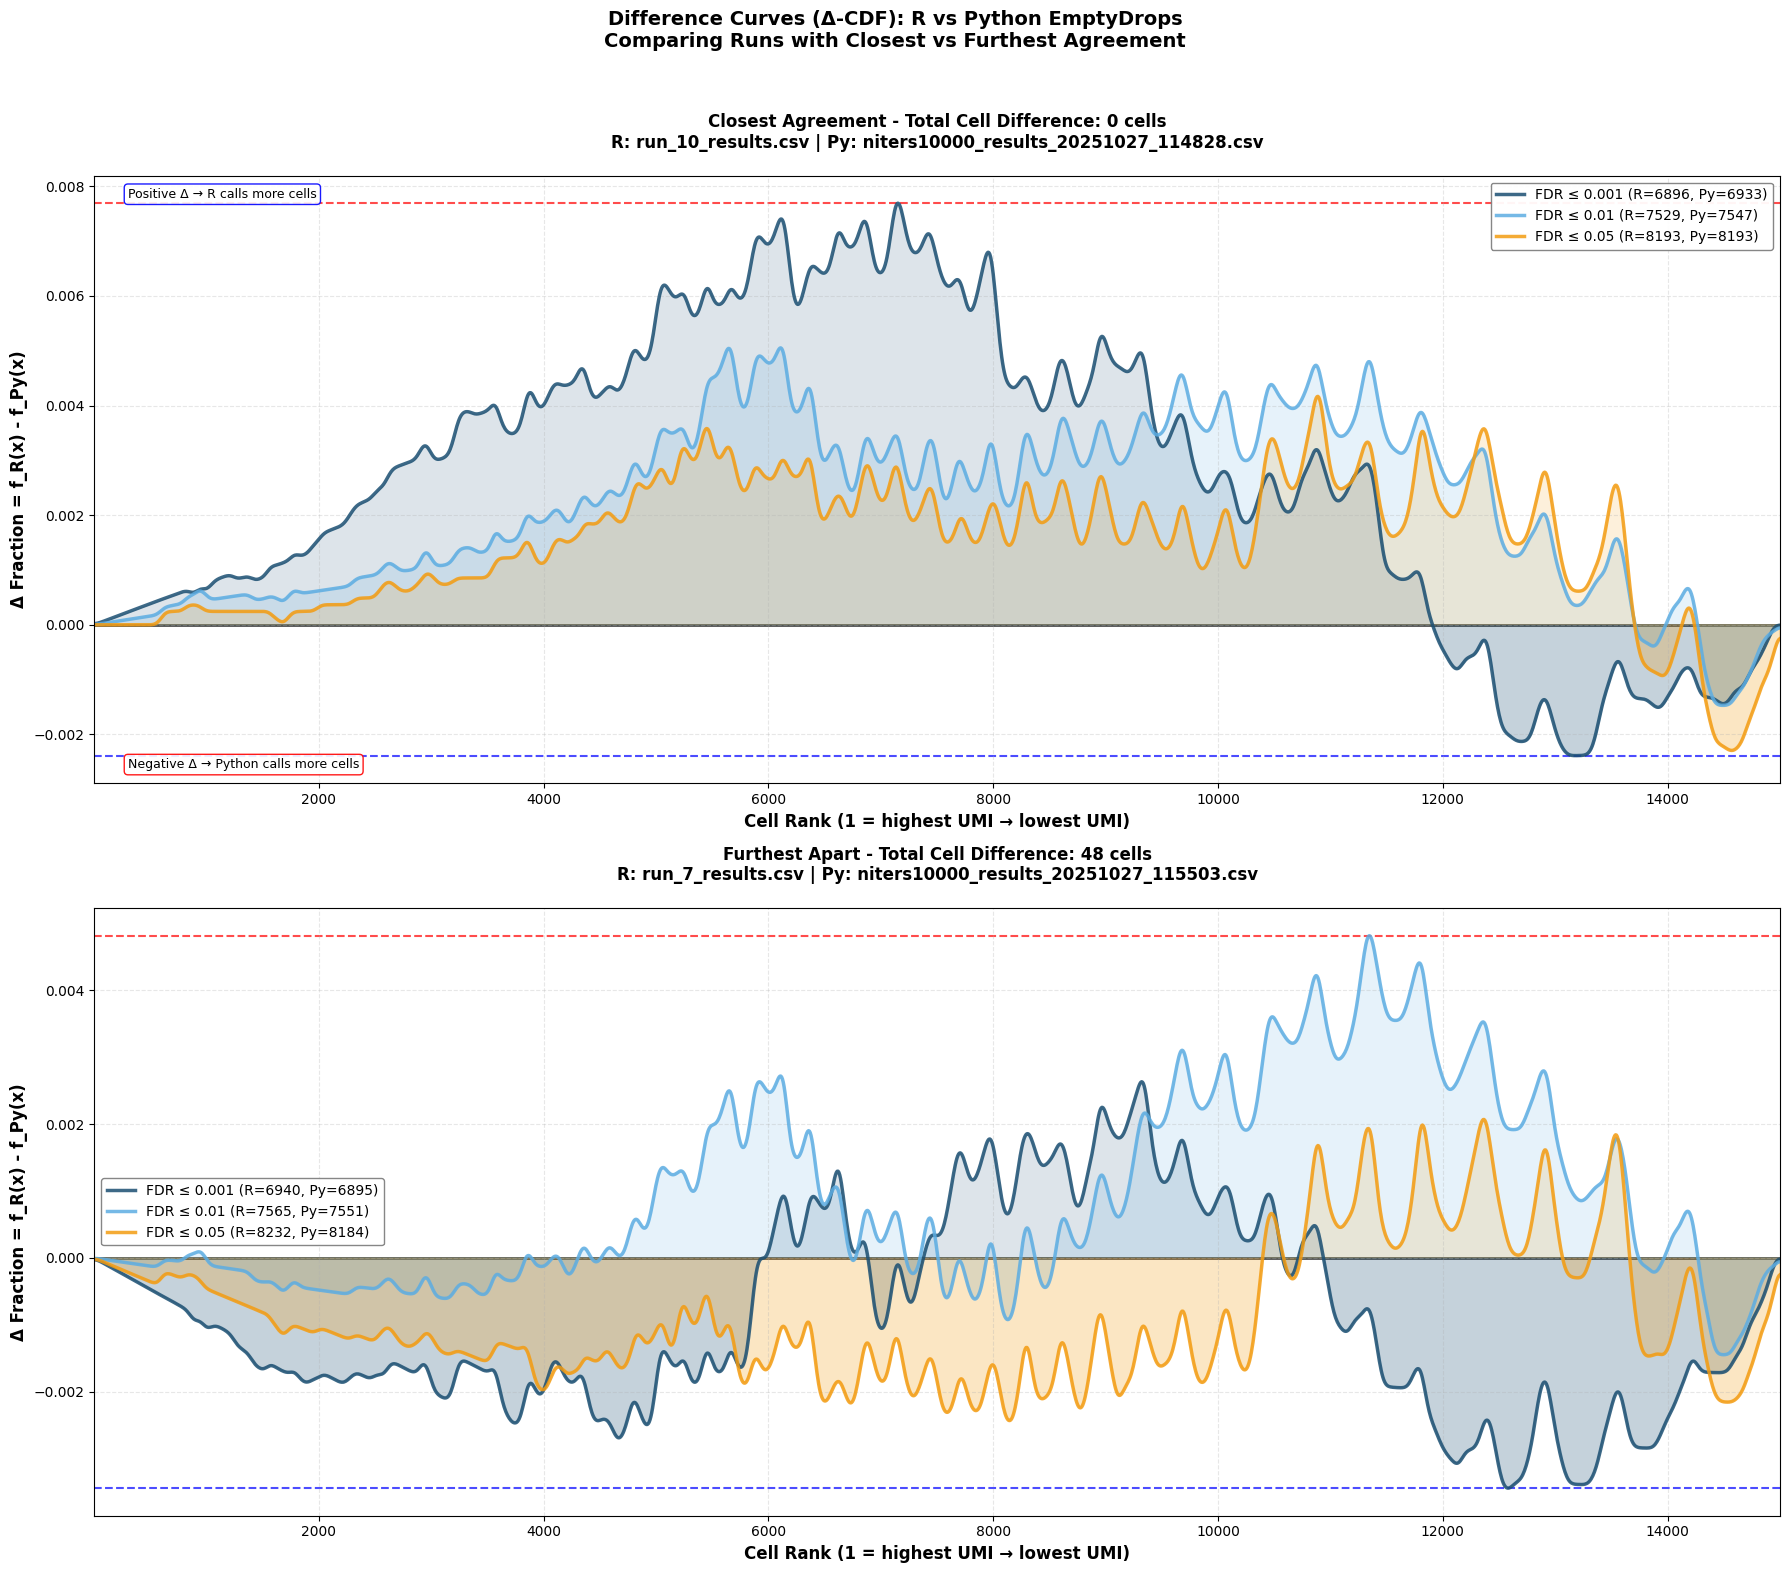


Saved: comparison_delta_fraction_closest_furthest.png

COMPARISON SUMMARY
Closest runs difference: 0 cells
  R: 8193 cells | Py: 8193 cells
Furthest runs difference: 48 cells
  R: 8232 cells | Py: 8184 cells
Range of disagreement: 48 cells


In [9]:
import glob
import os
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

print("=== Creating Difference Curve (Δ Fraction) Plot ===")

# Load all R and Python results files to find closest and furthest runs
r_files = glob.glob('../runs_R/run_*_results.csv')
py_files = glob.glob('../runs/niters10000_results_*.csv')

print(f"Found {len(r_files)} R files and {len(py_files)} Python files")

# Calculate total cells called for each run at FDR 0.05
run_comparisons = []

for r_file in r_files:
    r_results = pd.read_csv(r_file, index_col=0)
    r_test = r_results[r_results.index > 100].copy()
    r_called_005 = len(r_test[r_test['FDR'] <= 0.05])
    
    for py_file in py_files:
        py_results = pd.read_csv(py_file, index_col=0)
        py_test = py_results[py_results['Total'] > 100].copy()
        py_called_005 = len(py_test[py_test['FDR'] <= 0.05])
        
        diff = abs(py_called_005 - r_called_005)
        run_comparisons.append({
            'r_file': r_file,
            'py_file': py_file,
            'r_called': r_called_005,
            'py_called': py_called_005,
            'diff': diff,
            'r_name': r_file.split('/')[-1],
            'py_name': py_file.split('/')[-1]
        })

# Sort by difference to find closest and furthest
run_comparisons.sort(key=lambda x: x['diff'])
closest_run = run_comparisons[0]
furthest_run = run_comparisons[-1]

print(f"\nClosest runs (diff = {closest_run['diff']} cells):")
print(f"  R: {closest_run['r_name']} ({closest_run['r_called']} cells)")
print(f"  Py: {closest_run['py_name']} ({closest_run['py_called']} cells)")

print(f"\nFurthest runs (diff = {furthest_run['diff']} cells):")
print(f"  R: {furthest_run['r_name']} ({furthest_run['r_called']} cells)")
print(f"  Py: {furthest_run['py_name']} ({furthest_run['py_called']} cells)")

# Create plots for both closest and furthest runs
fig, axes = plt.subplots(2, 1, figsize=(18, 16))

for plot_idx, (run_info, ax, title_suffix) in enumerate([
    (closest_run, axes[0], "Closest Agreement"),
    (furthest_run, axes[1], "Furthest Apart")
]):
    
    print(f"\n=== Processing {title_suffix} ===")
    
    # Load the specific run files
    r_results = pd.read_csv(run_info['r_file'], index_col=0)
    py_results = pd.read_csv(run_info['py_file'], index_col=0)
    
    print(f"R: {run_info['r_name']} - {len(r_results)} cells")
    print(f"Py: {run_info['py_name']} - {len(py_results)} cells")
    
    # Filter for test cells (>100 UMI) and rank by total counts (descending)
    r_test = r_results[r_results.index > 100].copy()
    r_test = r_test.sort_values(by=r_test.index.name if r_test.index.name else 'Total', ascending=False)
    r_test = r_test.reset_index()
    r_test['Total'] = r_test.iloc[:, 0]  # First column after reset_index is the original index (Total counts)
    
    py_test = py_results[py_results['Total'] > 100].copy()
    py_test = py_test.sort_values('Total', ascending=False).reset_index(drop=True)
    
    r_test['rank'] = np.arange(1, len(r_test) + 1)
    py_test['rank'] = np.arange(1, len(py_test) + 1)
    
    print(f"Test cells (>100 UMI): R={len(r_test)}, Py={len(py_test)}")
    
    # Create a common rank grid for interpolation
    common_ranks = np.linspace(1, len(r_test), 2000)
    
    # Prepare data for all FDR thresholds
    fdr_thresholds = [0.001, 0.01, 0.05]
    colors = ['#1B4F72', '#5DADE2', '#F39C12']  # Dark blue → light blue → orange
    delta_data = []
    
    print(f"\nCalculating difference curves for {title_suffix}:")
    
    for fdr in fdr_thresholds:
        # Get cells called at this FDR threshold
        r_called = r_test[r_test['FDR'] <= fdr].copy()
        py_called = py_test[py_test['FDR'] <= fdr].copy()
        
        print(f"FDR ≤ {fdr}: R={len(r_called)}, Py={len(py_called)}, Diff={len(py_called)-len(r_called):+d}")
        
        if len(r_called) > 0 and len(py_called) > 0:
            # Calculate cumulative fractions
            r_ranks = np.sort(r_called['rank'].values)
            r_cumulative = np.arange(1, len(r_ranks) + 1) / len(r_ranks)
            
            py_ranks = np.sort(py_called['rank'].values)
            py_cumulative = np.arange(1, len(py_ranks) + 1) / len(py_ranks)
            
            # Interpolate to common grid
            r_interp_func = interp1d(r_ranks, r_cumulative, kind='linear', 
                                     bounds_error=False, fill_value=(0, 1))
            py_interp_func = interp1d(py_ranks, py_cumulative, kind='linear',
                                      bounds_error=False, fill_value=(0, 1))
            
            r_cumulative_interp = r_interp_func(common_ranks)
            py_cumulative_interp = py_interp_func(common_ranks)
            
            # Calculate difference: Δf(x) = f_R(x) - f_Py(x)
            delta_fraction = r_cumulative_interp - py_cumulative_interp
            
            # Smooth the curve slightly for visualization
            delta_fraction_smooth = gaussian_filter1d(delta_fraction, sigma=5)
            
            delta_data.append({
                'fdr': fdr,
                'ranks': common_ranks,
                'delta': delta_fraction_smooth,
                'n_r': len(r_called),
                'n_py': len(py_called)
            })
    
    # Find max/min for this specific comparison
    all_deltas = np.concatenate([data['delta'] for data in delta_data])
    max_pos = np.max(all_deltas)
    max_neg = np.min(all_deltas)
    
    # Plot each FDR threshold
    for i, data in enumerate(delta_data):
        fdr = data['fdr']
        ranks = data['ranks']
        delta = data['delta']
        
        # Plot the difference curve
        ax.plot(ranks, delta, color=colors[i], linewidth=2.5, 
               label=f"FDR ≤ {fdr} (R={data['n_r']}, Py={data['n_py']})", alpha=0.85)
        
        # Fill positive (R > Python) and negative (Python > R) regions
        ax.fill_between(ranks, 0, delta, where=(delta >= 0), 
                        color=colors[i], alpha=0.15, interpolate=True)
        ax.fill_between(ranks, 0, delta, where=(delta < 0), 
                        color=colors[i], alpha=0.25, interpolate=True)
    
    # Zero reference line
    ax.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.7, zorder=0)
    
    # Add horizontal lines for max/min
    ax.axhline(max_pos, color='red', linewidth=1.5, linestyle='--', alpha=0.7, zorder=1)
    ax.axhline(max_neg, color='blue', linewidth=1.5, linestyle='--', alpha=0.7, zorder=1)
    
    # Styling
    ax.set_xlabel('Cell Rank (1 = highest UMI → lowest UMI)', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Δ Fraction = f_R(x) - f_Py(x)', fontsize=12, fontweight='bold')
    ax.set_xlim([1, len(r_test)])
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
    ax.legend(loc='best', fontsize=10, framealpha=0.95, edgecolor='gray', fancybox=True)
    
    # Add title with run information
    ax.set_title(f'{title_suffix} - Total Cell Difference: {run_info["diff"]} cells\n'
                f'R: {run_info["r_name"]} | Py: {run_info["py_name"]}',
                fontsize=12, fontweight='bold', pad=20)
    
    # Add interpretation annotations
    if plot_idx == 0:  # Only on first plot to avoid repetition
        ax.text(0.02, 0.98, 'Positive Δ → R calls more cells', 
               transform=ax.transAxes, va='top', ha='left', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='blue'))
        
        ax.text(0.02, 0.02, 'Negative Δ → Python calls more cells', 
               transform=ax.transAxes, va='bottom', ha='left', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red'))

plt.suptitle('Difference Curves (Δ-CDF): R vs Python EmptyDrops\n'
             'Comparing Runs with Closest vs Furthest Agreement',
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('comparison_delta_fraction_closest_furthest.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: comparison_delta_fraction_closest_furthest.png")

# Print summary statistics
print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(f"Closest runs difference: {closest_run['diff']} cells")
print(f"  R: {closest_run['r_called']} cells | Py: {closest_run['py_called']} cells")
print(f"Furthest runs difference: {furthest_run['diff']} cells")
print(f"  R: {furthest_run['r_called']} cells | Py: {furthest_run['py_called']} cells")
print(f"Range of disagreement: {furthest_run['diff'] - closest_run['diff']} cells")
print("="*80)


# plot convergence in differences

Computing convergence for FDR ≤ 0.001...
Computing convergence for FDR ≤ 0.01...
Computing convergence for FDR ≤ 0.05...


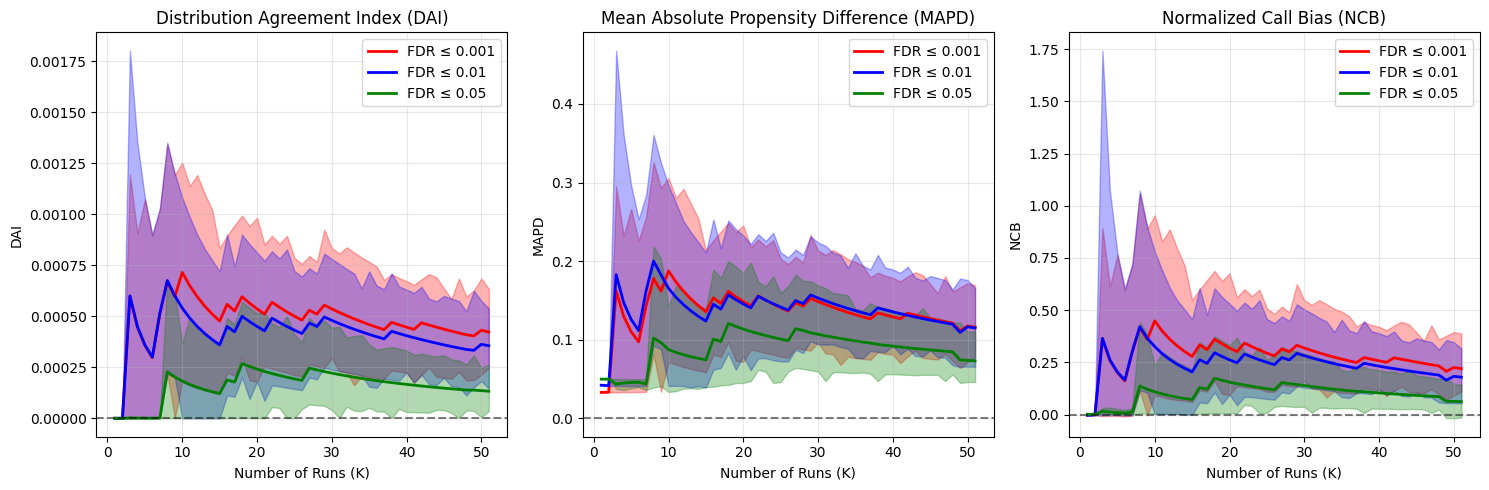


Saved: convergence_analysis.png

Convergence Analysis Complete!
Look for metrics that plateau above zero with tight CIs - these indicate genuine R↔Python discrepancies.


In [17]:
import numpy as np, pandas as pd
from scipy.interpolate import interp1d
from numpy.random import default_rng
import matplotlib.pyplot as plt
import glob
import os

rng = default_rng(7)

def cdf_from_called_ranks(called_ranks, n_called, grid):
    if n_called == 0:
        return np.zeros_like(grid)
    r = np.sort(called_ranks)
    y = np.arange(1, len(r)+1) / float(n_called)
    return interp1d(r, y, kind='previous', bounds_error=False, fill_value=(0.0, 1.0))(grid)

def build_reference_rank(tables, umi_min=100):
    # Extract barcode and Total columns, handling different column structures
    tots_list = []
    for t in tables:
        
        total_col = None
        if 'Total' in t.columns:
            total_col = 'Total'
        elif 'total' in t.columns:
            total_col = 'total'
        else:
            # Look for any numeric column that might represent totals
            numeric_cols = t.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                total_col = numeric_cols[0]  # Use first numeric column
            
        # Create barcode column if it doesn't exist
        temp_df = t.copy()
        if 'barcode' not in temp_df.columns:
            temp_df['barcode'] = temp_df.index.astype(str)
        
        tots_list.append(temp_df[['barcode', total_col]].rename(columns={total_col: 'Total'}))
    
    if not tots_list:
        raise ValueError("No valid tables with total columns found")
    
    tots = pd.concat(tots_list, ignore_index=True)
    med = tots.groupby('barcode', as_index=False)['Total'].median()
    med = med[med['Total'] > umi_min].sort_values('Total', ascending=False).reset_index(drop=True)
    med['rank'] = np.arange(1, len(med)+1)
    return med

def call_propensity_table(runs, ref, fdr, K):
    # runs: list of per-run DataFrames with ['barcode','Total','FDR','method','run']
    r_runs = [d for d in runs if d['method'].iloc[0]=='R'][:K]
    p_runs = [d for d in runs if d['method'].iloc[0]=='Py'][:K]
    nR, nP = len(r_runs), len(p_runs)
    # counts
    cntR = ref[['barcode']].assign(c=0).set_index('barcode')['c']
    cntP = cntR.copy()
    
    # Find FDR column with flexible naming, including FDR-specific columns
    def get_fdr_column(df, target_fdr):
        # First try FDR-specific columns
        fdr_str = str(target_fdr).replace('.', '_')
        fdr_cols = [f'fdr_{fdr_str}', f'FDR_{fdr_str}', f'fdr_{target_fdr}', f'FDR_{target_fdr}']
        for col in fdr_cols:
            if col in df.columns:
                return col, 'binary'  # These are binary columns (0/1 or True/False)
        
        # Then try general FDR columns
        for col in ['FDR', 'fdr', 'p_value', 'pvalue', 'p.value']:
            if col in df.columns:
                return col, 'threshold'  # These need thresholding
        
        return None, None
    
    for df in r_runs:
        fdr_col, col_type = get_fdr_column(df, fdr)
        if fdr_col is not None:
            if col_type == 'binary':
                # Binary column: 1 means called at this FDR level
                called = df.loc[df[fdr_col] == 1, 'barcode'].unique()
            else:
                # Threshold column: compare against FDR threshold
                called = df.loc[df[fdr_col] <= fdr, 'barcode'].unique()
            cntR.loc[cntR.index.intersection(called)] += 1
        else:
            print(f"Warning: No FDR column found for FDR={fdr} in R run with columns {list(df.columns)}")
    
    for df in p_runs:
        fdr_col, col_type = get_fdr_column(df, fdr)
        if fdr_col is not None:
            if col_type == 'binary':
                # Binary column: 1 means called at this FDR level
                called = df.loc[df[fdr_col] == 1, 'barcode'].unique()
            else:
                # Threshold column: compare against FDR threshold
                called = df.loc[df[fdr_col] <= fdr, 'barcode'].unique()
            cntP.loc[cntP.index.intersection(called)] += 1
        else:
            print(f"Warning: No FDR column found for FDR={fdr} in Python run with columns {list(df.columns)}")
    
    tab = ref.copy()
    tab['p_R']  = cntR.reindex(ref['barcode']).to_numpy() / max(1,nR)
    tab['p_Py'] = cntP.reindex(ref['barcode']).to_numpy() / max(1,nP)
    tab['dp']   = tab['p_R'] - tab['p_Py']
    return tab, nR, nP

def compute_indices(r_runs_all, py_runs_all, ref, fdr, K, grid):
    # CDFs
    def mean_cdf(method_runs):
        cdfs = []
        for df in method_runs:
            # Find FDR column with flexible naming, including FDR-specific columns
            def get_fdr_column(df, target_fdr):
                # First try FDR-specific columns
                fdr_str = str(target_fdr).replace('.', '_')
                fdr_cols = [f'fdr_{fdr_str}', f'FDR_{fdr_str}', f'fdr_{target_fdr}', f'FDR_{target_fdr}']
                for col in fdr_cols:
                    if col in df.columns:
                        return col, 'binary'
                
                # Then try general FDR columns
                for col in ['FDR', 'fdr', 'p_value', 'pvalue', 'p.value']:
                    if col in df.columns:
                        return col, 'threshold'
                
                return None, None
            
            fdr_col, col_type = get_fdr_column(df, fdr)
            
            if fdr_col is None:
                print(f"Warning: No FDR column found for FDR={fdr} in run with columns {list(df.columns)}")
                # Create empty CDF if no FDR column
                cdfs.append(np.zeros_like(grid))
                continue
            
            # Get called cells based on column type
            if col_type == 'binary':
                called_mask = df[fdr_col] == 1
            else:
                called_mask = df[fdr_col] <= fdr
            
            called = df.loc[called_mask, 'rank'].to_numpy() if 'rank' in df else None
            if called is None:
                # rank by ref map (safer if per-run orders differ)
                m = ref[['barcode','rank']].set_index('barcode')['rank']
                called = m.loc[m.index.intersection(df.loc[called_mask,'barcode'])].to_numpy()
            cdfs.append(cdf_from_called_ranks(called, len(called), grid))
        return np.mean(np.stack(cdfs, axis=0), axis=0)

    Rk = r_runs_all[:K]; Pk = py_runs_all[:K]
    fR = mean_cdf(Rk); fP = mean_cdf(Pk)
    DAI = np.trapz(np.abs(fR - fP), x=grid) / (grid[-1]-grid[0])

    # MAPD
    tab, nR, nP = call_propensity_table(r_runs_all+py_runs_all, ref, fdr, K)
    MAPD = tab['dp'].abs().mean()

    # NCB
    def count_called(runs):
        counts = []
        for df in runs:
            # Find FDR column with flexible naming, including FDR-specific columns
            def get_fdr_column(df, target_fdr):
                # First try FDR-specific columns
                fdr_str = str(target_fdr).replace('.', '_')
                fdr_cols = [f'fdr_{fdr_str}', f'FDR_{fdr_str}', f'fdr_{target_fdr}', f'FDR_{target_fdr}']
                for col in fdr_cols:
                    if col in df.columns:
                        return col, 'binary'
                
                # Then try general FDR columns
                for col in ['FDR', 'fdr', 'p_value', 'pvalue', 'p.value']:
                    if col in df.columns:
                        return col, 'threshold'
                
                return None, None
            
            fdr_col, col_type = get_fdr_column(df, fdr)
            if fdr_col is not None:
                if col_type == 'binary':
                    counts.append((df[fdr_col] == 1).sum())
                else:
                    counts.append((df[fdr_col] <= fdr).sum())
            else:
                counts.append(0)
        return counts
    
    nR_counts = count_called(Rk)
    nP_counts = count_called(Pk)
    nR_mean = np.mean(nR_counts)
    nP_mean = np.mean(nP_counts)
    denom = 0.5*(nR_mean+nP_mean) if (nR_mean+nP_mean)>0 else 1.0
    NCB  = (nR_mean - nP_mean)/denom
    return DAI, MAPD, NCB

def bootstrap_indices(r_runs_all, py_runs_all, ref, fdr, K, grid, B=500):
    Rk = r_runs_all[:K]; Pk = py_runs_all[:K]
    vals = []
    for _ in range(B):
        Rb = [Rk[i] for i in rng.integers(0,len(Rk),len(Rk))]
        Pb = [Pk[i] for i in rng.integers(0,len(Pk),len(Pk))]
        DAI, MAPD, NCB = compute_indices(Rb, Pb, ref, fdr, K, grid)
        vals.append((DAI, MAPD, NCB))
    arr = np.array(vals)
    return arr.mean(0), np.percentile(arr, [2.5,97.5], axis=0)  # mean, CI

# Load data
def load_runs():
    # Load Python runs
    py_files = glob.glob('../runs/*.csv')
    py_runs = []
    for i, f in enumerate(py_files):
        df = pd.read_csv(f)
        df['method'] = 'Py'
        df['run'] = i
        py_runs.append(df)
    
    # Load R runs
    r_files = glob.glob('../runs_R/*.csv')
    r_runs = []
    for i, f in enumerate(r_files):
        df = pd.read_csv(f, index_col=0)
        # R results have totals as index, need to convert
        df = df.reset_index()
        df.rename(columns={'index': 'Total'}, inplace=True)
        # Create barcode column from row index (not the Total column)
        df['barcode'] = range(len(df))  # Use row position as barcode
        df['barcode'] = df['barcode'].astype(str)
        df['method'] = 'R'
        df['run'] = i
        r_runs.append(df)
    
    return py_runs, r_runs

# Build reference ranking
py_runs, r_runs = load_runs()
all_tables = py_runs + r_runs
ref = build_reference_rank(all_tables)

# Add ranks to all runs - ensure barcode column exists first
for df in py_runs + r_runs:
    # Ensure barcode column exists
    if 'barcode' not in df.columns:
        df['barcode'] = df.index.astype(str)
    
    rank_map = ref.set_index('barcode')['rank']
    df['rank'] = rank_map.reindex(df['barcode']).fillna(np.inf)

# Parameters
fdrs = [0.001, 0.01, 0.05]
K_values = range(1, min(len(py_runs), len(r_runs)) + 1)
grid = np.linspace(1, len(ref), 1000)

# Compute convergence
results = {fdr: {'K': [], 'DAI': [], 'MAPD': [], 'NCB': [], 
                'DAI_ci': [], 'MAPD_ci': [], 'NCB_ci': []} for fdr in fdrs}

for fdr in fdrs:
    print(f"Computing convergence for FDR ≤ {fdr}...")
    for K in K_values:
        # Point estimates
        DAI, MAPD, NCB = compute_indices(r_runs, py_runs, ref, fdr, K, grid)
        
        # Bootstrap CIs
        (DAI_boot, MAPD_boot, NCB_boot), cis = bootstrap_indices(r_runs, py_runs, ref, fdr, K, grid, B=200)
        
        results[fdr]['K'].append(K)
        results[fdr]['DAI'].append(DAI)
        results[fdr]['MAPD'].append(MAPD)
        results[fdr]['NCB'].append(NCB)
        results[fdr]['DAI_ci'].append(cis[:, 0])
        results[fdr]['MAPD_ci'].append(cis[:, 1])
        results[fdr]['NCB_ci'].append(cis[:, 2])

# Plot convergence
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['red', 'blue', 'green']
metrics = ['DAI', 'MAPD', 'NCB']
titles = ['Distribution Agreement Index (DAI)', 'Mean Absolute Propensity Difference (MAPD)', 'Normalized Call Bias (NCB)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    
    for j, fdr in enumerate(fdrs):
        K_vals = results[fdr]['K']
        vals = results[fdr][metric]
        cis = np.array(results[fdr][f'{metric}_ci'])
        
        # Plot line and CI ribbon
        ax.plot(K_vals, vals, color=colors[j], label=f'FDR ≤ {fdr}', linewidth=2)
        ax.fill_between(K_vals, cis[:, 0], cis[:, 1], color=colors[j], alpha=0.3)
    
    ax.set_xlabel('Number of Runs (K)')
    ax.set_ylabel(metric)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: convergence_analysis.png")
print("\nConvergence Analysis Complete!")
print("Look for metrics that plateau above zero with tight CIs - these indicate genuine R↔Python discrepancies.")


# threshold based analysis

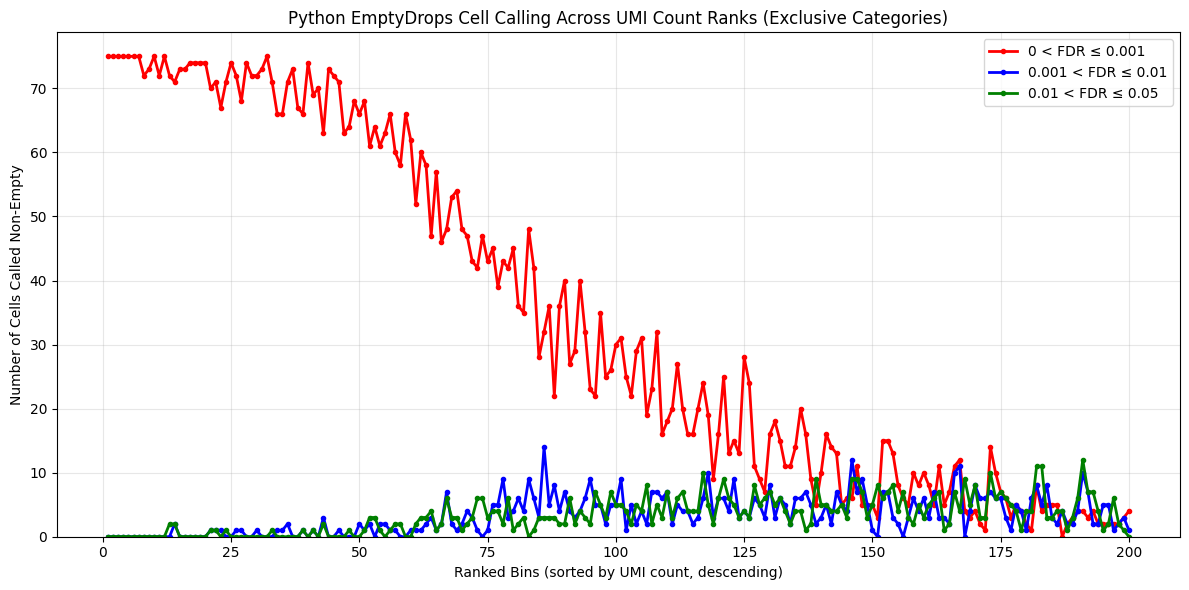


Saved: threshold_analysis_by_rank_exclusive.png

Threshold-based Analysis Complete!
This plot shows the absolute number of cells called as non-empty
in each ranked bin for different FDR thresholds (exclusive categories).
Cells are assigned to the most stringent FDR threshold they pass.


In [15]:
# Load the data for threshold-based analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Python results from CSV file (using niters=10000 results as done above)
df = pd.read_csv('../runs/niters10000_results_20251027_150852.csv')

# only take the rows out of the df where FDR isnt empty (should be 15000 in total)
df = df[df['FDR'].notna()]
# Extract UMI counts and FDR values
umi_counts = df['Total'].values
fdr_values = df['FDR'].values
fdrs = [0.001, 0.01, 0.05]
n_bins = 200

# Get Python results for each FDR threshold by filtering
python_results = {}
for fdr in fdrs:
    # Create boolean array: True if FDR <= threshold (non-empty), False otherwise
    python_results[fdr] = fdr_values <= fdr

# Create exclusive categories for each FDR threshold
# Cells are assigned to the most stringent FDR they pass
exclusive_results = {}
for fdr in fdrs:
    exclusive_results[fdr] = np.zeros(len(fdr_values), dtype=bool)

# Assign cells to exclusive FDR categories (most stringent first)
for i in range(len(fdr_values)):
    if python_results[0.001][i]:  # Most stringent
        exclusive_results[0.001][i] = True
    elif python_results[0.01][i]:  # Medium stringent
        exclusive_results[0.01][i] = True
    elif python_results[0.05][i]:  # Least stringent
        exclusive_results[0.05][i] = True

# Sort cells by UMI count (descending order)
sorted_indices = np.argsort(umi_counts)[::-1]
sorted_umi = umi_counts[sorted_indices]

# Create bins based on ranked cells
cells_per_bin = len(sorted_umi) // n_bins
bin_edges = np.arange(0, len(sorted_umi) + cells_per_bin, cells_per_bin)
if bin_edges[-1] < len(sorted_umi):
    bin_edges = np.append(bin_edges, len(sorted_umi))

# Calculate absolute count of cells called as non-empty for each FDR and bin
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = ['red', 'blue', 'green']

for i, fdr in enumerate(fdrs):
    # Get sorted exclusive results for this FDR
    sorted_results = exclusive_results[fdr][sorted_indices]
    
    # Calculate absolute count of non-empty calls in each ranked bin
    counts_per_bin = np.zeros(len(bin_edges) - 1)
    
    for j in range(len(bin_edges) - 1):
        start_idx = bin_edges[j]
        end_idx = bin_edges[j + 1]
        bin_results = sorted_results[start_idx:end_idx]
        
        # Absolute count of cells called as non-empty (True values)
        counts_per_bin[j] = np.sum(bin_results)
    
    # Create bin centers for x-axis (ranked bin numbers)
    bin_centers = np.arange(1, len(counts_per_bin) + 1)
    
    # Plot line for this FDR threshold
    ax.plot(bin_centers, counts_per_bin, color=colors[i], 
            label=f'{0 if i==0 else fdrs[i-1]} < FDR ≤ {fdr}', linewidth=2, marker='o', markersize=3)

ax.set_xlabel('Ranked Bins (sorted by UMI count, descending)')
ax.set_ylabel('Number of Cells Called Non-Empty')
ax.set_title('Python EmptyDrops Cell Calling Across UMI Count Ranks (Exclusive Categories)')
ax.legend()
ax.grid(True, alpha=0.3)

# Set y-axis to start from 0
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('threshold_analysis_by_rank_exclusive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: threshold_analysis_by_rank_exclusive.png")
print("\nThreshold-based Analysis Complete!")
print("This plot shows the absolute number of cells called as non-empty")
print("in each ranked bin for different FDR thresholds (exclusive categories).")
print("Cells are assigned to the most stringent FDR threshold they pass.")


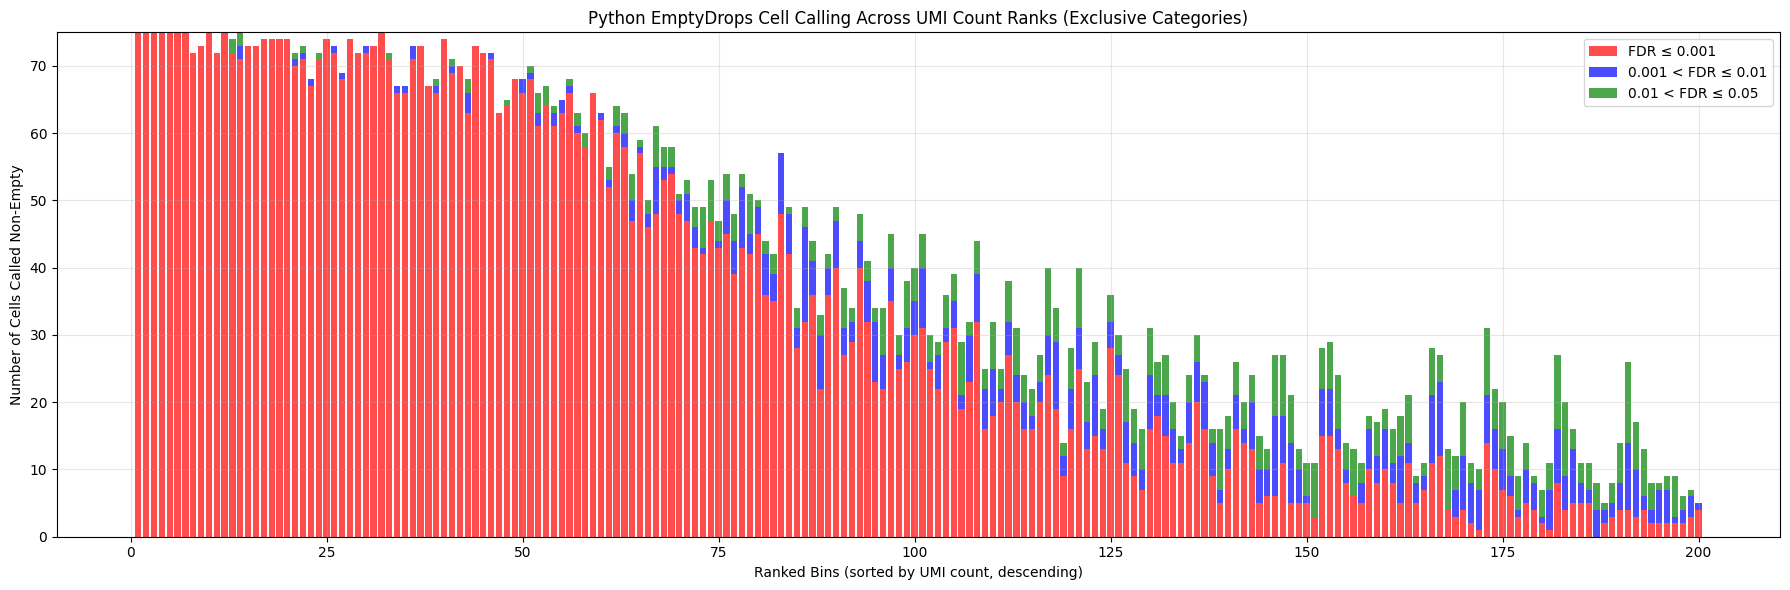


Saved: threshold_analysis_by_rank_exclusive.png

Threshold-based Analysis Complete!
This plot shows the absolute number of cells called as non-empty
in each ranked bin for different FDR thresholds (exclusive categories).
Cells are assigned to the most stringent FDR threshold they pass.


In [16]:
# Load the data for threshold-based analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Python results from CSV file (using niters=10000 results as done above)
df = pd.read_csv('../runs/niters10000_results_20251027_150852.csv')

# only take the rows out of the df where FDR isnt empty (should be 15000 in total)
df = df[df['FDR'].notna()]
# Extract UMI counts and FDR values
umi_counts = df['Total'].values
fdr_values = df['FDR'].values
fdrs = [0.001, 0.01, 0.05]
n_bins = 200

# Get Python results for each FDR threshold by filtering (exclusive categories)
python_results = {}
for i, fdr in enumerate(fdrs):
    if i == 0:
        # First threshold: FDR <= 0.001
        python_results[fdr] = fdr_values <= fdr
    else:
        # Subsequent thresholds: previous_threshold < FDR <= current_threshold
        prev_fdr = fdrs[i-1]
        python_results[fdr] = (fdr_values > prev_fdr) & (fdr_values <= fdr)

# Sort cells by UMI count (descending order)
sorted_indices = np.argsort(umi_counts)[::-1]
sorted_umi = umi_counts[sorted_indices]

# Create bins based on ranked cells
cells_per_bin = len(sorted_umi) // n_bins
bin_edges = np.arange(0, len(sorted_umi) + cells_per_bin, cells_per_bin)
if bin_edges[-1] < len(sorted_umi):
    bin_edges = np.append(bin_edges, len(sorted_umi))

# Calculate absolute count of cells called as non-empty for each FDR and bin
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
colors = ['red', 'blue', 'green']

# Calculate counts for all FDR thresholds
all_counts = []
for i, fdr in enumerate(fdrs):
    # Get sorted results for this FDR
    sorted_results = python_results[fdr][sorted_indices]
    
    # Calculate absolute count of non-empty calls in each ranked bin
    counts_per_bin = np.zeros(len(bin_edges) - 1)
    
    for j in range(len(bin_edges) - 1):
        start_idx = bin_edges[j]
        end_idx = bin_edges[j + 1]
        bin_results = sorted_results[start_idx:end_idx]
        
        # Absolute count of cells called as non-empty (True values)
        counts_per_bin[j] = np.sum(bin_results)
    
    all_counts.append(counts_per_bin)

# Create bin centers for x-axis (ranked bin numbers)
bin_centers = np.arange(1, len(all_counts[0]) + 1)

# Create stacked bar plot
bottom = np.zeros(len(bin_centers))
for i, fdr in enumerate(fdrs):
    if i == 0:
        label = f'FDR ≤ {fdr}'
    else:
        prev_fdr = fdrs[i-1]
        label = f'{prev_fdr} < FDR ≤ {fdr}'
    
    ax.bar(bin_centers, all_counts[i], bottom=bottom, color=colors[i], 
           alpha=0.7, label=label, width=0.8)
    bottom += all_counts[i]

ax.set_xlabel('Ranked Bins (sorted by UMI count, descending)')
ax.set_ylabel('Number of Cells Called Non-Empty')
ax.set_title('Python EmptyDrops Cell Calling Across UMI Count Ranks (Exclusive Categories)')
ax.legend()
ax.grid(True, alpha=0.3)

# Set y-axis to start from 0
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('threshold_analysis_by_rank_exclusive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: threshold_analysis_by_rank_exclusive.png")
print("\nThreshold-based Analysis Complete!")
print("This plot shows the absolute number of cells called as non-empty")
print("in each ranked bin for different FDR thresholds (exclusive categories).")
print("Cells are assigned to the most stringent FDR threshold they pass.")
